In [30]:
import pandas as pd

df = pd.read_csv("company-bankruptcy-prediction.csv")

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 設定顯示樣式，讓圖表好看一點
sns.set(style="whitegrid")

# 1. 基本檢查
print(f"資料筆數: {df.shape[0]}, 特徵數量: {df.shape[1]}")
print("-" * 30)
print(df.info())
print(df.isnull().sum().sum())

資料筆數: 6819, 特徵數量: 96
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                           

破產與否分佈：
Bankrupt?
0    6599
1     220
Name: count, dtype: int64

比例分佈：
Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64


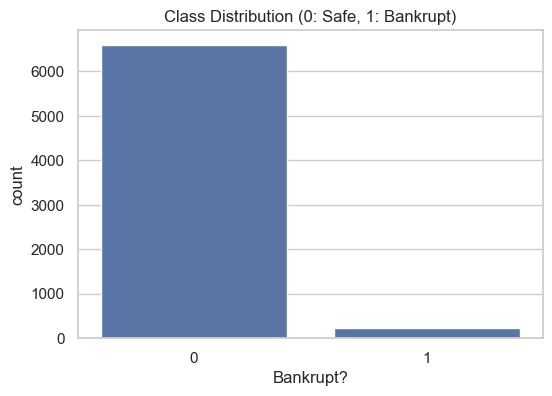

In [32]:
# 假設目標欄位名稱是 'Bankrupt?' (Kaggle這份資料常見的名稱)
target_col = 'Bankrupt?'

count = df[target_col].value_counts()
percent = df[target_col].value_counts(normalize=True)

print("破產與否分佈：")
print(count)
print("\n比例分佈：")
print(percent)

# 畫圖比較有感
plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title('Class Distribution (0: Safe, 1: Bankrupt)')
plt.show()

In [34]:
df.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

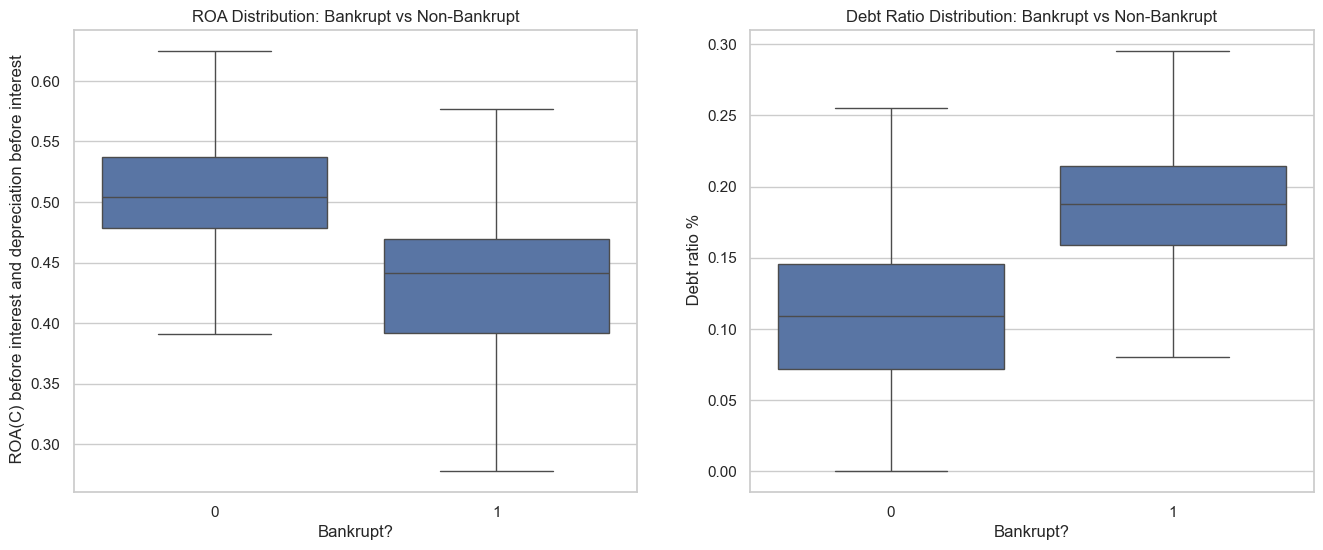

In [36]:
# 這裡需要你確認一下實際的欄位名稱，Kaggle這份資料名稱通常很長
# 假設名稱如下 (請依實際 header 調整)：
# 'ROA(C) before interest and depreciation before interest'
# 'Debt ratio %'

# 為了方便示範，我先用簡稱，你實作時請換成真實欄位名
feature_roa = ' ROA(C) before interest and depreciation before interest'
feature_debt = ' Debt ratio %'

# 畫 Boxplot (箱型圖) 是比較兩群人差異最好的工具
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x=target_col, y=feature_roa, data=df, ax=ax[0], showfliers=False)
ax[0].set_title('ROA Distribution: Bankrupt vs Non-Bankrupt')

sns.boxplot(x=target_col, y=feature_debt, data=df, ax=ax[1], showfliers=False)
ax[1].set_title('Debt Ratio Distribution: Bankrupt vs Non-Bankrupt')

plt.show()

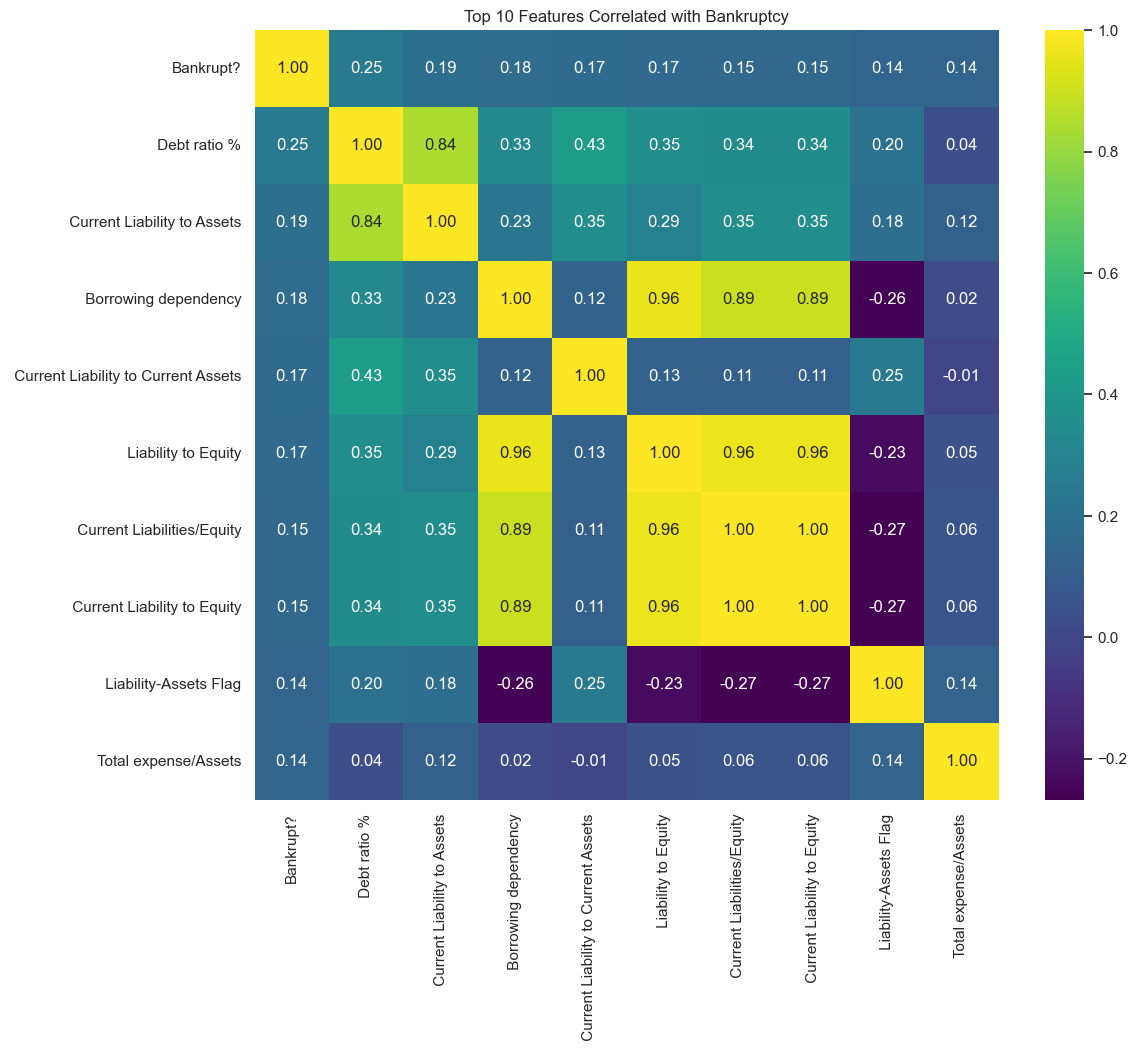

In [37]:
# 我們不跑全部95個特徵，先跑跟「破產」相關係數最高的 Top 10
k = 10 # 取前10個
cols = df.corr().nlargest(k, target_col)[target_col].index

plt.figure(figsize=(12, 10))
sns.heatmap(df[cols].corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Top 10 Features Correlated with Bankruptcy')
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df.drop(columns=['Bankrupt?'])
y = df['Bankrupt?']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9729
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1320
           1       0.82      0.20      0.33        44

    accuracy                           0.97      1364
   macro avg       0.90      0.60      0.66      1364
weighted avg       0.97      0.97      0.96      1364

Confusion Matrix:
[[1318    2]
 [  35    9]]


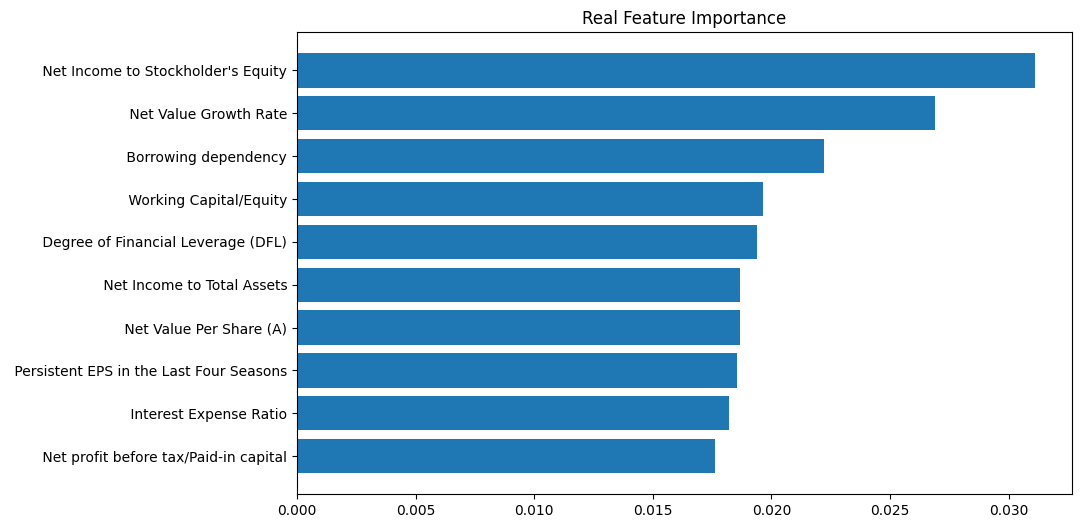

In [15]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature':X.columns,
    'Importance':importances
    }).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.gca().invert_yaxis()
plt.title('Real Feature Importance')
plt.show()

In [56]:
# 1. 取得模型預測為「破產 (Class 1)」的機率
y_probs = rf_model.predict_proba(X_test)[:, 1]

# 2. 設定一個較低的門檻 (試試看 0.2，甚至是 0.1)
threshold = 0.1
y_pred_adjusted = (y_probs > threshold).astype(int)

# 3. 重新檢視成績單
print(f"--- Threshold = {threshold} ---")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

--- Threshold = 0.1 ---
Confusion Matrix:
[[1253   67]
 [  10   34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1320
           1       0.34      0.77      0.47        44

    accuracy                           0.94      1364
   macro avg       0.66      0.86      0.72      1364
weighted avg       0.97      0.94      0.95      1364



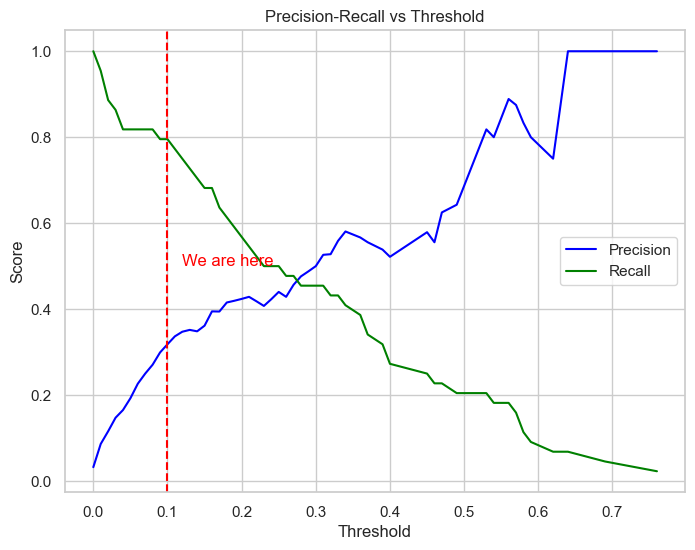

In [57]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 1. 計算各種閾值下的 P 和 R
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# 2. 畫圖
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)

# 3. 標出你剛剛選的 0.1 位置
plt.axvline(x=0.1, color='red', linestyle='--', label='Threshold 0.1')
plt.text(0.12, 0.5, 'We are here', color='red')
plt.show()

In [59]:
from imblearn.over_sampling import SMOTE

# 1. 初始化 SMOTE
# sampling_strategy=0.5 表示把破產資料生成到跟正常資料的比例變成 1:2 (原本是 1:30 幾)
smote = SMOTE(sampling_strategy=0.5, random_state=42)

# 2. 只對「訓練集 (X_train)」做生成！絕對不能對測試集做！
# (這點超級重要，就像不能把考古題拿去當期末考題一樣)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"原始訓練集 1 的數量: {sum(y_train == 1)}")
print(f"SMOTE後訓練集 1 的數量: {sum(y_train_smote == 1)}")

# 3. 用新的、比較平衡的資料重新訓練模型
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_smote.fit(X_train_smote, y_train_smote)

# 4. 預測與評估
y_pred_smote = rf_smote.predict(X_test)

print("\n--- After SMOTE ---")
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))

原始訓練集 1 的數量: 176
SMOTE後訓練集 1 的數量: 2639

--- After SMOTE ---
[[1296   24]
 [  20   24]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.50      0.55      0.52        44

    accuracy                           0.97      1364
   macro avg       0.74      0.76      0.75      1364
weighted avg       0.97      0.97      0.97      1364



In [60]:
# 使用你剛剛訓練好的 SMOTE 模型 (rf_smote)
y_probs_smote = rf_smote.predict_proba(X_test)[:, 1]

# 我們試著把門檻從預設的 0.5 稍微降到 0.3
threshold = 0.3
y_pred_final = (y_probs_smote > threshold).astype(int)

print(f"--- SMOTE + Threshold {threshold} ---")
print(confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))

--- SMOTE + Threshold 0.3 ---
[[1252   68]
 [  10   34]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1320
           1       0.33      0.77      0.47        44

    accuracy                           0.94      1364
   macro avg       0.66      0.86      0.72      1364
weighted avg       0.97      0.94      0.95      1364



C:\Users\peter\AppData\Local\Temp\ipykernel_7936\3639931896.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


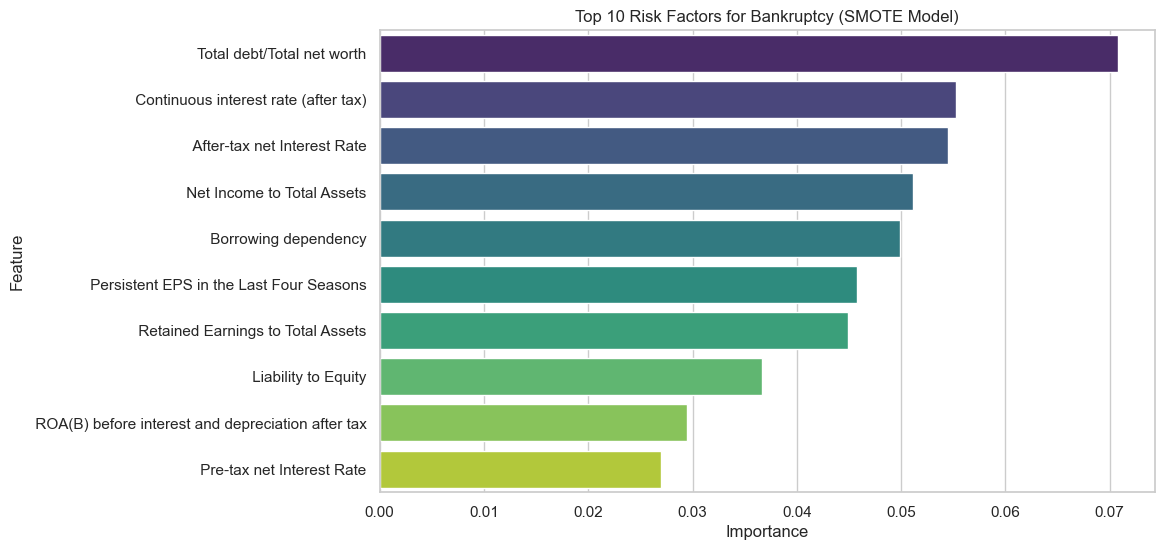

In [61]:
# 取得特徵重要性數值
importances = rf_smote.feature_importances_
feature_names = X.columns

# 整理成 DataFrame 並排序
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(10)

# 畫圖
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Top 10 Risk Factors for Bankruptcy (SMOTE Model)')
plt.show()

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 設定評分卡參數 (這是銀行常用的標準設定)
target_score = 600    # 當好壞比為 50:1 時，給 600 分
target_odds = 50
pdo = 20              # 每當好壞比翻倍 (變好)，分數 +20 分

# 計算轉換係數 (Factor & Offset)
factor = pdo / np.log(2)
offset = target_score - (factor * np.log(target_odds))

# 2. 準備機率資料 (使用測試集)
# 注意：你的模型輸出的是「違約率 (P_Bad)」
p_bad = rf_smote.predict_proba(X_test)[:, 1]

# 防呆機制：避免機率為 0 或 1 導致 log 出錯 (數學上 log(0) 無定義)
p_bad = np.clip(p_bad, 0.001, 0.999)

# 3. 計算 Odds (好壞比)
# Odds = 活下來的機率 / 倒閉的機率
odds = (1 - p_bad) / p_bad

# 4. 計算分數
scores = offset + (factor * np.log(odds))
scores = scores.astype(int) # 轉成整數

# 把分數存回 DataFrame 方便觀察
df_score = pd.DataFrame({
    'Actual_Status': y_test, # 0: 正常, 1: 破產
    'Prob_Bankruptcy': p_bad,
    'Credit_Score': scores
})

# 看看前幾筆
print(df_score.head(10))

      Actual_Status  Prob_Bankruptcy  Credit_Score
1244              0            0.040           578
6303              0            0.020           599
4712              0            0.001           686
3273              0            0.001           686
6430              0            0.010           619
3255              0            0.530           483
3758              0            0.130           541
6037              0            0.550           481
985               0            0.001           686
5371              0            0.020           599


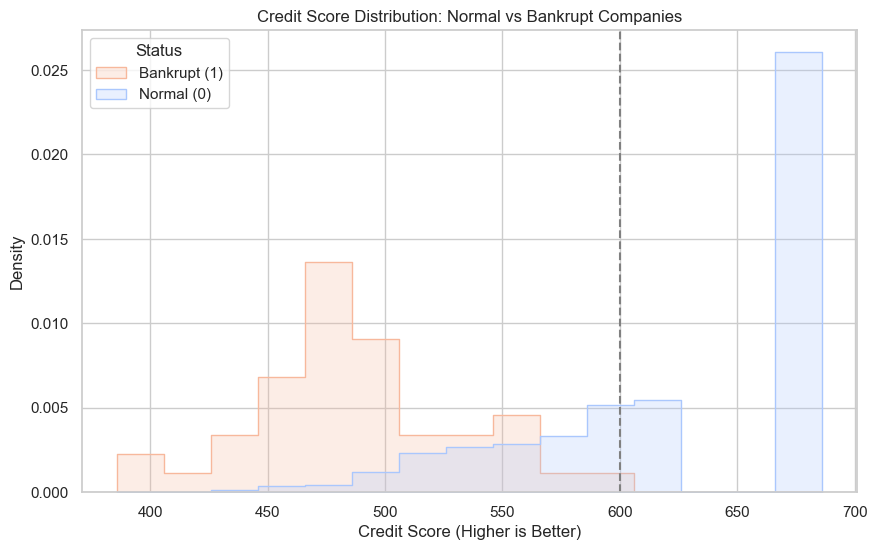

In [63]:
plt.figure(figsize=(10, 6))

# 畫出兩群人的分數分佈
sns.histplot(data=df_score, x='Credit_Score', hue='Actual_Status', 
             element='step', stat='density', common_norm=False, palette='coolwarm')

plt.title('Credit Score Distribution: Normal vs Bankrupt Companies')
plt.xlabel('Credit Score (Higher is Better)')
plt.ylabel('Density')
plt.axvline(x=600, color='gray', linestyle='--', label='Base Score (600)')
plt.legend(title='Status', labels=['Bankrupt (1)', 'Normal (0)'])
plt.show()

In [64]:
import joblib

# 1. 儲存模型 (就像存檔一樣)
# 我們把「模型」和「評分卡參數」都存起來
model_package = {
    'model': rf_smote,          # 訓練好的模型
    'threshold': 0.3,           # 最佳門檻
    'score_params': {           # 評分卡參數
        'factor': factor,
        'offset': offset
    }
}

joblib.dump(model_package, 'bankruptcy_scorecard_model.pkl')

print("模型已成功打包存檔！檔名：bankruptcy_scorecard_model.pkl")

模型已成功打包存檔！檔名：bankruptcy_scorecard_model.pkl
